[View in Colaboratory](https://colab.research.google.com/github/planewave/coherent_receiver_with_CNN/blob/master/CFO_recovery_for_sc80.ipynb)

apply pre trained CNN (cfo_v3) to sea trial data for CFO recovery

In [5]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu90' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
from torch import nn

tcmalloc: large alloc 1073750016 bytes == 0x5db42000 @  0x7f1c103301c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [4]:
# upload file sc80sps1.mat and net.pt
from google.colab import files
uploaded = files.upload()
with open(list(uploaded.keys())[0], 'wb') as f: # 'wb' file in binary mode not str.
    f.write(uploaded[list(uploaded.keys())[0]]) # note how to index dict

Saving net.pt to net.pt


In [0]:
import numpy as np
from scipy import io
from matplotlib import pyplot as plt

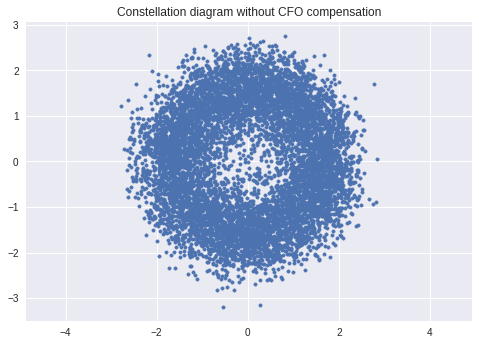

In [3]:
sc80 = io.loadmat('sc80sps1.mat')['data_dec']
ref = io.loadmat('sc80sps1.mat')['pn_ref']

plt.scatter(sc80.real, sc80.imag, marker='.')
plt.axis('equal')
plt.title('Constellation diagram without CFO compensation')
plt.show()

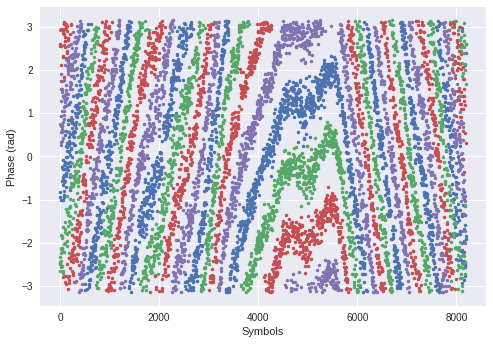

In [6]:
phase = np.angle(sc80)
sig0, sig1, sig2, sig3 = phase.copy(), phase.copy(), phase.copy(), phase.copy()
sig0[ref != ref[0]] = np.nan
sig1[ref != ref[1]] = np.nan
sig2[ref != ref[3]] = np.nan
sig3[ref != ref[13]] = np.nan
plt.plot(sig0, '.', sig1, '.', sig2, '.', sig3, '.')
plt.xlabel('Symbols')
plt.ylabel('Phase (rad)')
plt.show()

In [0]:
CUDA = True
M = 4
PI = 3.1416
LEN = 100
DATA_NUM = 5000
# BATCH_SIZE = 200
# LR = 1e-4 # learning rate
dtype = torch.float

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, 3),
            nn.ReLU(),
            )

        self.lin = nn.Linear(32, 1)

    def forward(self, x_in):
        cnn_out = self.cnn(x_in)
        cfo = self.lin(cnn_out.view(cnn_out.size(0), -1))
        return cfo

net = NET().cuda()
# load the pre-trained network 
net.load_state_dict(torch.load('net.pt'))

In [0]:
dtype = torch.float
device = torch.device("cuda:0")
LEN = 32
rec = torch.tensor(phase, device=device, dtype=dtype).view(1, 1, -1)
y_est = torch.zeros_like(rec)
phase_off = torch.zeros(1, 1, device=device, dtype=dtype)
phase_rcd = []

step_size = 4

for step in range(2041):
    frame = (rec[:, :, step*step_size: step*step_size+LEN]-phase_off+np.pi)%(2*np.pi)-np.pi
    cfo = net(frame)
    phase_off += cfo
    y_est[:, :, step*step_size: step*step_size+step_size] = frame[:, :, 0:step_size] - cfo

y_est = y_est.cpu().squeeze().detach().numpy()

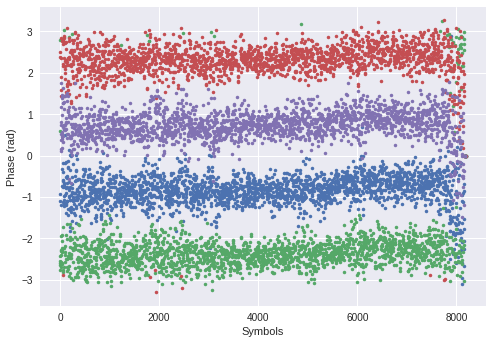

In [9]:
sig0, sig1, sig2, sig3 = y_est.copy(), y_est.copy(), y_est.copy(), y_est.copy()
ref = ref.squeeze()
sig0[ref != ref[0]] = np.nan
sig1[ref != ref[1]] = np.nan
sig2[ref != ref[3]] = np.nan
sig3[ref != ref[13]] = np.nan
plt.plot(sig0, '.', sig1, '.', sig2, '.',sig3, '.')
# plt.xlim(0, 200)
plt.xlabel('Symbols')
plt.ylabel('Phase (rad)')
plt.show()